<a href="https://colab.research.google.com/github/DavideScassola/PML2024/blob/main/./Notebooks/08_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 8: Expectation Maximization

## The problem

Given a model 

$$p(\boldsymbol{X}, \boldsymbol{Z} | \boldsymbol{\theta})$$

where $\boldsymbol{X}$ is observed, but $\boldsymbol{Z}$ si latent and $\boldsymbol{\theta}$ is also unknown, the objective is to find:

$$\boldsymbol{\theta}_{ML} = \argmax_{\boldsymbol{\theta}} p(\boldsymbol{X} | \boldsymbol{\theta})$$

This could be intractable for two reasons:
- you may need to sum over all possible combinations of latent variables' assignments $\boldsymbol{Z}$:
$$p(\boldsymbol{X} | \boldsymbol{\theta}) = \sum_{\boldsymbol{Z}} p(\boldsymbol{X}, \boldsymbol{Z} | \boldsymbol{\theta})$$
- the summation could be tractable but not numerically stable (you cannot use log-probabilities).



**Remark:**
What's the difference between the unknown latent variables $\boldsymbol{z}_i$ and unknown parameters $\boldsymbol{\theta}$? The objetive is to find the $\boldsymbol{\theta}$ that better explains the data (maximum likelihood estimation), while inferring each $\boldsymbol{z}_i$ is sometimes secondary.

Example:

Given the following dataset of points:

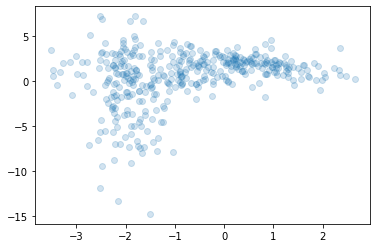

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

x = np.load('data/em.npy')
_ = plt.scatter(x[:, 0], x[:, 1], alpha=0.2)

you want to model them according to a mixture of 3 gaussians:

$$ p(\boldsymbol{x}_i, z_i | \boldsymbol{\theta}) = p(\boldsymbol{x}_i | z_i, \boldsymbol{\theta}) p(z_i | \boldsymbol{\theta})$$
$$ p(\boldsymbol{x}_i | z_i, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{x}_i; \mu_{z_i}, \Sigma_{z_i})$$
$$ P(z_i = k | \boldsymbol{\theta}) = \pi_{k}$$

where $z_i \in \{0, 1, 2\}$ and $\boldsymbol{\theta} = (\mu_{0}, \Sigma_{0}, \pi_0, \mu_{1}, \Sigma_{1}, \pi_1, \mu_{2}, \Sigma_{2}, \pi_2)$.


<img src="imgs/EM1.png" alt="drawing" width="200"/>

You want to find the set of parameters $\boldsymbol{\theta}$ that maximizes $p(\boldsymbol{x} | \boldsymbol{\theta})$, for example, since you are interested in the shapes and location of these three gaussians. Unfortunately this is intractable for numerical reasons.

Expectation Maximization is an algorithm that allows to find an approximated solution to this problem.

## Expectation Maximization

The idea of EM is to alternate the estimation of the distribution of latent variables $q(\boldsymbol{Z})$ keeping fixed the global parameters $\boldsymbol{\theta}$ (Expectation step), to the optimization of the global parameters keeping fixed the distribution of latent variables (Maximization step) until convergence is reached.

**EM algorithm:**
1. Initialize $\boldsymbol{\theta}$
2. Repeat until convergence:
    - E step: $q(\boldsymbol{Z}) \leftarrow p(\boldsymbol{Z} | \boldsymbol{X}, \boldsymbol{\theta})$
    - M step: $\boldsymbol{\theta} \leftarrow \argmax_{\boldsymbol{\theta}} \mathbb{E}_{q(\boldsymbol{Z})} p(\boldsymbol{X}, \boldsymbol{Z} | \boldsymbol{\theta})$

### Expectation step
We assume $p(\boldsymbol{Z} | \boldsymbol{X}, \boldsymbol{\theta})$ is easy to compute, in this case we have:
$$p(\boldsymbol{Z} | \boldsymbol{X}, \boldsymbol{\theta}) = \prod_i p(\boldsymbol{z}_i | \boldsymbol{x}_i, \boldsymbol{\theta})$$
where:
$$p(\boldsymbol{z}_i | \boldsymbol{x}_i, \boldsymbol{\theta}) \propto p(\boldsymbol{x}_i | \boldsymbol{z}_i, \boldsymbol{\theta})p(\boldsymbol{z}_i | \boldsymbol{\theta})$$
so the distribution for every $\boldsymbol{z}_i$ is:
$$q(\boldsymbol{z}_i) \propto p(\boldsymbol{x}_i | \boldsymbol{z}_i, \boldsymbol{\theta})p(\boldsymbol{z}_i | \boldsymbol{\theta})$$

### Maximization step
Having fixed $q(\boldsymbol{z}_i) \forall i$, we find $\boldsymbol{\theta} = \argmax_{\boldsymbol{\theta}} \mathbb{E}_{q(\boldsymbol{Z})} p(\boldsymbol{X}, \boldsymbol{Z} | \boldsymbol{\theta})$.

Depending on the problem, this can be done analytically or by optimization.

### Gaussian mixture example

Let's go back to the previous example:

\begin{align*}
& p(\boldsymbol{x}_i | z_i, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{x}_i; \mu_{z_i}, \Sigma_{z_i}) \\
& P(z_i = k | \boldsymbol{\theta}) = \pi_{k}
\end{align*}

where $z_i \in \{0, 1, 2\}$ and $\boldsymbol{\theta} = (\mu_{0}, \Sigma_{0}, \pi_0, \mu_{1}, \Sigma_{1}, \pi_1, \mu_{2}, \Sigma_{2}, \pi_2)$.


**Expectation step:**

In [2]:
from typing import Tuple
import torch
from torch.distributions import MultivariateNormal

def p_x_given_z_theta(x: torch.Tensor, z, theta: dict) -> torch.Tensor:
    return MultivariateNormal(loc=theta['mean'][z],
                              covariance_matrix=theta['cov'][z]).log_prob(x).exp()

    
def p_z_given_theta(z:  torch.Tensor, theta: dict)-> torch.Tensor:
    return theta['pi'][z]


def p_z_given_x_theta(x:  torch.Tensor, theta: dict) -> torch.Tensor:
    z = torch.stack([p_x_given_z_theta(x, k, theta) * p_z_given_theta(k, theta) for k in range(len(theta['pi']))], dim=1)
    z = z / z.sum(dim=1, keepdim=True)
    return z

**Maximization Step:**

For the Gaussian Mixture case, the maximization step can be done analytically. It consists in computing weighted means and covariances:

\begin{gather*}
    \mu_j^{new} = \frac{1}{N_j} \sum_n q(z_{n}=j)x_n \\
    \Sigma_j^{new} = \frac{1}{N_j} \sum_n q(z_{n}=j) (x_n - \mu_j^{new})^T(x_n - \mu_j^{new}) \\
    \pi_j^{new} = \frac{N_j}{N}, \qquad N_j = \sum_{n=1}^N q(z_{n} = j)
\end{gather*}

In [3]:
def weighted_mean_cov(x: torch.Tensor, w: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    w = w.unsqueeze(1) / w.sum()
    mean = (x*w).sum(0)
    centered_x = x - mean
    cov = (centered_x.unsqueeze(1) * centered_x.unsqueeze(2) * w.reshape(-1,1,1)).sum(0)
    return mean, cov

def update_theta(x: torch.Tensor, q_z: torch.Tensor) -> dict:
    pi = q_z.mean(dim=0)
    means = torch.zeros(q_z.shape[1], x.shape[1])
    covs = torch.zeros(q_z.shape[1], x.shape[1], x.shape[1])
    for k in range(q_z.shape[1]):
        means[k], covs[k] = weighted_mean_cov(x, q_z[:,k])    
    return {'pi': pi, 'mean':  means, 'cov': covs}

**EM algorithm**

In [4]:
from tqdm.notebook import tqdm

def EM(x: torch.Tensor, theta_init: dict, max_iter: int = 100):
    theta = theta_init
    for _ in tqdm(range(max_iter)):
        q_z = p_z_given_x_theta(x, theta)
        theta = update_theta(x, q_z)
    return theta, p_z_given_x_theta(x, theta)


Now use EM to find $\theta$ and $p(Z | \boldsymbol{X}, \theta)$

In [5]:
theta_init = {'pi': torch.tensor([1/3, 1/3, 1/3]),
              
                'mean': torch.tensor([[-1, -1],
                                      [0, 0],
                                      [1, 1]]).float(),
                
                'cov': torch.tensor([[[1, 0],
                                      [0, 1]],
                                     
                                     [[1, 0],
                                      [0, 1]],
                                        
                                      [[1, 0],
                                       [0, 1]]]).float()*100}

theta, q_z = EM(torch.tensor(x), theta_init)

print(theta)

  0%|          | 0/100 [00:00<?, ?it/s]

{'pi': tensor([0.3013, 0.4424, 0.2564]), 'mean': tensor([[-1.9535, -1.7773],
        [-0.8660,  1.2497],
        [ 0.6628,  1.9906]]), 'cov': tensor([[[ 0.1488, -0.1952],
         [-0.1952, 19.0142]],

        [[ 1.4381,  0.0822],
         [ 0.0822,  2.1052]],

        [[ 0.6781, -0.5485],
         [-0.5485,  0.7672]]])}


Let's plot every point with $p(z_i | \boldsymbol{x}_i, \theta)$

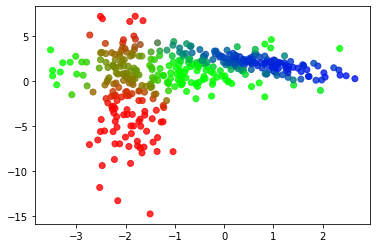

In [6]:
_ = plt.scatter(x[:, 0], x[:, 1], c= q_z.numpy(), alpha=0.8)

Let's compare it with K-means

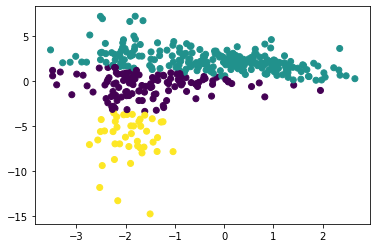

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto', random_state=0)
kmeans.fit(x)
_ = plt.scatter(x[:, 0], x[:, 1], c=kmeans.labels_, cmap='viridis')

It is common to use the result of k-means to initialize the parameters for EM:

  0%|          | 0/100 [00:00<?, ?it/s]

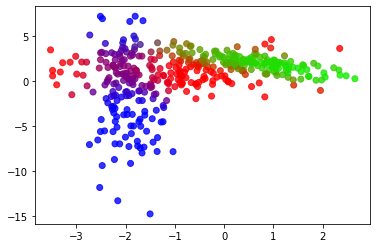

In [8]:
z = kmeans.labels_

pi = np.bincount(z) / len(z) # proportion of each cluster

means = np.array([x[z == k].mean(0) for k in range(3)])

covs = np.array([np.cov(x[z == k].T) for k in range(3)])

theta_init_k_means = {'pi': torch.tensor(pi),
                      'mean': torch.tensor(means).float(),
                      'cov': torch.tensor(covs).float()}

theta, q_z = EM(torch.tensor(x), theta_init_k_means)
_ = plt.scatter(x[:, 0], x[:, 1], c= q_z.numpy(), alpha=0.8)